In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Курсовой проект от "Мегафон"**
**Задание для проекта:**

У нас появился запрос из отдела продаж и маркетинга. Как вы знаете «МегаФон» предлагает обширный набор различных услуг своим абонентам. При этом разным пользователям интересны разные услуги. Поэтому необходимо построить  алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

**Данные**

В качестве исходных данных вам будет доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить.
Отдельным набором данных будет являться нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента. Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени.
Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц. 
Итого, в качестве входных данных будут представлены:
data_train.csv: id, vas_id, buy_time, target
features.csv.zip: id, <feature_list> 

И тестовый набор:
data_test.csv: id, vas_id, buy_time
target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
id - идентификатор абонента
vas_id - подключаемая услуга
Примечание: Размер файла features.csv в распакованном виде весит 20 гб, для работы  с ним можно воспользоваться pandas.read_csv, либо можно воспользоваться библиотекой Dask.
Метрика
Скоринг будет осуществляться функцией f1, невзвешенным образом, как например делает функция sklearn.metrics.f1_score(…, average=’macro’).
 sklearn.metrics.f1_score — scikit-learn 0.22.1 documentation

**Формат представления результата**

Работающая модель в формате pickle, которая принимает файл data_test.csv из корневой папки и записывает в эту же папку файл answers_test.csv. В этом файле должны находится 4 столбца: buy_time, id, vas_id и target. Target можно записать как вероятность подключения услуги.
Код модели можно представить в виде jupyter-ноутбука. 
Презентация в формате .pdf, в которой необходимо отразить:
Информация о модели, ее параметрах, особенностях и основных результатах.
Обоснование выбора модели и ее сравнение с альтернативами.
Принцип составления индивидуальных предложений для выбранных абонентов.
Рекомендуемое количество слайдов – 5 – 10.
Файл answers test.csv с результатами работы модели, презентацию, ноутбуки и резюме необходимо прикрепить ко второму уроку “курсовой проект”.


### **Подключение библиотек**

In [ ]:
import pandas as pd; pd.set_option('display.max_columns', None)
import dask.dataframe as dd
from dask.distributed import Client, progress

### **Загрузка данных**

In [ ]:
!unzip '/content/drive/MyDrive/Megafon_project/features.csv.zip'

Archive:  /content/drive/MyDrive/Megafon_project/features.csv.zip
  inflating: features.csv            
  inflating: __MACOSX/._features.csv  


In [ ]:
df_train = dd.read_csv('/content/drive/MyDrive/Megafon_project/data_train.csv')
df_test = dd.read_csv('/content/drive/MyDrive/Megafon_project/data_test.csv')
df_features = dd.read_csv('/content/features.csv',sep='\t')

In [ ]:
df_train.head()

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


In [ ]:
df_test.head()

,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [ ]:
df_features.head()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,49.520873,38.19189,-0.000725,-0.016435,-0.107041,-1.17746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-42.026959,-2841.496068,-1085.821501,-1755.674564,-89.504287,-119.724355,-70.712019,-54.069191,-16.642826,-7.896282,-5.634035,-10.717958,-28.571103,57.869716,52.911014,26.828289,26.668705,-4.958702,38.254749,-1.671324,-0.001656,1.318354,2.117335,-0.265234,0.331838,0.078356,-0.237576,0.254338,-0.028454,-0.044465,3.698872,26.411990,-0.036834,3.869969,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275915,-3.950157,-0.253037,-0.318148,-2.29064,-3.447583,-0.040043,-9.408469,4.027863,-11.955314,-1.019293,-0.473446,-2.62084,-1087.017387,-1757.811263,-0.36799,0.396143,-2844.828651,-2298.725139,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211948,-119.674411,-208.886358,-0.058077,0.129549,0.274871,-3.618164,-11.681641,-0.573283,0.531557,0.582717,-190.670372,1.856777,3.277409,2.174027,4.064012,0.0,-1.276187,-0.020137,-0.042636,-29.797016,-70.470802,-14.96363,-34.888325,-3.861461,-0.317164,-0.007024,-0.143269,60.582329,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,-4.678214,-0.014542,0.280492,-21.183166,-44.376426,-25.320085,-51.984826,-23.961228,-54.128903,-11.614497,-30.288386,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793637,-1.932758,-5.008096,-9.978121,-16.684052,4.645192,13.112964,-0.034569,-0.163184,-109.036398,0.533317,-1.929048,0.376263,-0.228106,-0.251959,-0.000567,0.566264,-0.000708,-0.02921,0.895335,-0.001358,0.0,0.039208,0.665644,-0.008999,-11953.712824,-45175.257711,0.377099,-30.716053,-61790.157098,-0.243136,-42051.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.595373e+08,-42.014078,-4.405604e+08,1.356414e+09,5.565998,-1.465191,-33.302382,-249.128986,-36.772492,-0.364694,-0.133771,-0.209468,-32.356505,-109.884564,-876.69102,-5.368281,-247.110707,-108.409742,-512.437331,-84.617978,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,-6.783660,-26.544905,-2.736081,-4.007526,-2.558912,67.300873,55.97189,-0.000725,-0.016435,-0.107041,15.77254,-3.178521,411.379185,-10.744164,-0.094251,-0.001733,-0.009327,131.407791,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-192.026959,-2937.657200,-1181.982633,-1755.674564,447.193953,1258.981645,-119.662019,-54.6025

Во всех датасетах существует столбец "buy_time" и индекс "Unnamed:0". В дальнейшем нам работать с индексами, поэтому переименуем для удобства 

In [ ]:
def operator(name):
    return {'Unnamed: 0': f'index_{name}', 
            'buy_time': f'buy_time_{name}'}

train_df = dd.read_csv('/content/drive/MyDrive/Megafon_project/data_train.csv').rename(columns=operator('vt'))
test_df = dd.read_csv('/content/drive/MyDrive/Megafon_project/data_test.csv').rename(columns=operator('vt'))
features_df = dd.read_csv('/content/features.csv',sep='\t').rename(columns=operator('ft'))

In [ ]:
train_df.head()

,index_vt,id,vas_id,buy_time_vt,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0


In [ ]:
test_df.head()

,index_vt,id,vas_id,buy_time_vt
0,0,3130519,2.0,1548018000
1,1,2000860,4.0,1548018000
2,2,1099444,2.0,1546808400
3,3,1343255,5.0,1547413200
4,4,1277040,2.0,1546808400


In [ ]:
features_df.head()

,index_ft,id,buy_time_ft,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,49.520873,38.19189,-0.000725,-0.016435,-0.107041,-1.17746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-42.026959,-2841.496068,-1085.821501,-1755.674564,-89.504287,-119.724355,-70.712019,-54.069191,-16.642826,-7.896282,-5.634035,-10.717958,-28.571103,57.869716,52.911014,26.828289,26.668705,-4.958702,38.254749,-1.671324,-0.001656,1.318354,2.117335,-0.265234,0.331838,0.078356,-0.237576,0.254338,-0.028454,-0.044465,3.698872,26.411990,-0.036834,3.869969,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275915,-3.950157,-0.253037,-0.318148,-2.29064,-3.447583,-0.040043,-9.408469,4.027863,-11.955314,-1.019293,-0.473446,-2.62084,-1087.017387,-1757.811263,-0.36799,0.396143,-2844.828651,-2298.725139,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211948,-119.674411,-208.886358,-0.058077,0.129549,0.274871,-3.618164,-11.681641,-0.573283,0.531557,0.582717,-190.670372,1.856777,3.277409,2.174027,4.064012,0.0,-1.276187,-0.020137,-0.042636,-29.797016,-70.470802,-14.96363,-34.888325,-3.861461,-0.317164,-0.007024,-0.143269,60.582329,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,-4.678214,-0.014542,0.280492,-21.183166,-44.376426,-25.320085,-51.984826,-23.961228,-54.128903,-11.614497,-30.288386,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793637,-1.932758,-5.008096,-9.978121,-16.684052,4.645192,13.112964,-0.034569,-0.163184,-109.036398,0.533317,-1.929048,0.376263,-0.228106,-0.251959,-0.000567,0.566264,-0.000708,-0.02921,0.895335,-0.001358,0.0,0.039208,0.665644,-0.008999,-11953.712824,-45175.257711,0.377099,-30.716053,-61790.157098,-0.243136,-42051.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.595373e+08,-42.014078,-4.405604e+08,1.356414e+09,5.565998,-1.465191,-33.302382,-249.128986,-36.772492,-0.364694,-0.133771,-0.209468,-32.356505,-109.884564,-876.69102,-5.368281,-247.110707,-108.409742,-512.437331,-84.617978,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,-6.783660,-26.544905,-2.736081,-4.007526,-2.558912,67.300873,55.97189,-0.000725,-0.016435,-0.107041,15.77254,-3.178521,411.379185,-10.744164,-0.094251,-0.001733,-0.009327,131.407791,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-192.026959,-2937.657200,-1181.982633,-1755.674564,447.193953,1258.981645,-119.662019,-54.602

In [ ]:
len(train_df.index)

831653

In [ ]:
len(test_df.index)

71231

Необходимо проверить, есть ли данные (которые есть в train_df и test_df) для всех id в features_df... Для этого проведем слияние features_df с train_df и features_df с test_df по id

In [ ]:
train_feature = (dd.merge(train_df, features_df, on=['id'], how='inner')).compute()
train_feature.head()

,index_vt,id,vas_id,buy_time_vt,target,index_ft,buy_time_ft,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,140,4130548,2.0,1544389200,0.0,8832,1548018000,11.700029,17.790888,4.429214,-10.646798,-0.988246,-31.75179,7.85382,29.933903,-3.863189,-14.606532,-2.736081,17.012004,-2.558912,18.370873,7.04189,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-7.270815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,20.71061,-0.065583,-0.700765,-43.026959,-598.379904,-1068.177947,469.798136,-89.504287,-119.724355,-47.728685,-23.919190,-23.809498,-7.896282,-6.822342,-10.707745,-28.565596,-17.130284,-21.088986,-22.171711,-1.331295,-3.958702,0.254749,-0.671324,-0.001656,50.318354,7.117335,0.114766,-0.098162,0.038356,0.192424,0.044338,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-0.324022,9.293562,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275915,-3.950157,-0.253037,-0.318148,-2.29064,-0.947583,-0.040043,-9.408469,-0.212137,-11.955314,-1.019293,-1.473446,-4.62084,-1069.373833,467.661437,0.30201,-0.203857,-601.712487,44.862861,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211948,-119.674411,-208.886358,0.011923,-0.060451,-0.265129,18.381836,17.318359,1.426717,-0.468443,-0.417283,-190.670372,15.856777,22.277409,8.174027,13.064012,0.0,-1.276187,-0.020137,-0.042636,11.452984,105.979198,-19.96363,-9.888325,-2.861461,0.282836,-0.007024,0.456731,-14.417671,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,-3.678214,-0.014542,-0.029508,4.816834,-29.009759,0.679915,-33.001492,23.038772,-23.978902,-11.614497,-28.471719,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793637,-1.932758,-5.008096,30.021879,-23.850720,-16.354808,-35.303704,-0.034569,-0.163184,-109.036398,0.533317,-1.929048,-0.623737,-0.228106,-0.251959,-0.000567,0.566264,-0.000708,-0.02921,-0.104665,-0.001358,0.0,0.039208,0.665644,-0.008999,-11953.712824,-45053.257711,0.377099,-34.616053,-61798.157098,-0.243136,-42051.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,9.758669e+08,-46.464078,-4.405604e+08,-1.204418e+08,-11.580668,-1.465191,-33.302382,-225.128986,0.227508,-0.364694,-0.133771,-0.209468,-4.356505,-109.884564,1082.30898,-1.368281,703.889293,-108.409742,491.562669,-105.617978,-17.295406,-943.373846,-598.770792,-25.996269,-22.630448,-220.747724,-14.832889,-0.694428,-12.175933,-0.45614,1.0
1,842,540997,1.0,1541365200,0.0,11897,1545598800,-96.799971,-69.199112,-108.200786,-112.916798,-113.618246,-134.02179,-16.08618,-65.076097,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-11.400815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-192.026

In [ ]:
train_feature.shape[0]

860052

In [ ]:
test_feature = (dd.merge(test_df, features_df, on=['id'], how='inner')).compute()
test_feature.head()

,index_vt,id,vas_id,buy_time_vt,index_ft,buy_time_ft,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,16,1054895,2.0,1546808400,2612,1538946000,-41.699971,-235.389112,-55.640786,-287.996798,-61.058246,-309.10179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-22.41811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,-0.799862,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-192.026959,-2942.440404,-1186.765837,-1755.674564,-89.504287,-119.724355,-36.245355,-37.402524,1.157176,-7.896282,-7.337336,-10.717958,-28.571103,-38.130284,-43.088986,-65.171711,-21.331295,-4.958702,-8.745251,-1.671324,-0.001656,-27.681646,-3.882665,-0.265234,-0.058162,0.068356,-0.237576,-0.125662,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-2.824022,-7.486438,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275915,-3.950157,-0.253037,-0.318148,18.90936,-3.447583,-0.040043,45.691531,-0.212137,43.144686,-1.019293,-1.473446,-2.62084,-1187.961723,-1757.811263,-0.36799,-0.393857,-2945.772987,-2298.725139,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211948,-119.674411,-208.886358,-0.058077,-0.060451,-0.575129,-2.618164,-7.681641,1.426717,0.531557,0.182717,-190.670372,-1.143223,-2.722591,-0.825973,-1.935988,0.0,-1.276187,-0.020137,-0.042636,-5.463684,-71.070802,-32.96363,-26.888325,-3.861461,0.182836,-0.007024,-0.143269,-35.417671,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,-4.678214,-0.014542,0.100492,-18.183166,-27.176426,-11.320085,14.231844,-22.961228,-37.462236,-12.614497,-19.005052,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793637,-1.932758,-5.008096,-16.978121,1.115950,-10.354808,6.579626,-0.034569,-0.163184,16.802092,-0.466683,1.070952,-0.623737,-0.228106,-0.251959,-0.000567,-0.433736,-0.000708,-0.02921,-0.104665,-0.001358,0.0,0.039208,-0.334356,-0.008999,-6680.085824,-45175.257711,-0.622901,-30.716053,-61790.157098,0.756864,-41561.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,-5.726695e+08,-58.544078,1.061442e+09,-1.204418e+08,24.232664,-1.465191,-33.302382,-266.128986,-39.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,-876.69102,-5.368281,-247.110707,-108.409742,-512.437331,-106.617978,-17.295406,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,920,1055365,2.0,1548018000,2614,1544994000,-92.219971,-105.459112,-106.160786,-158.066798,-111.578246,-179.17179,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-72.93811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,0.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583

In [ ]:
test_feature.shape[0]

73666

Итак, выходит, что после слияния таблиц количество наблюдений увеличилось. Это говорит о том, что есть дубликаты в данных. Возможно у некоторых клиентов было несколько записей в разное время. Необходимо избавиться от дубликатов. Оставим дубликаты с наименьшей разницей между buy_time_vt и buy_time_ft. И создадим новый столбец time_diff (разница) 

In [ ]:
def buy_time_clear(df):
    df['time_diff'] = abs(df['buy_time_vt'] - df['buy_time_ft'])
 
    df.sort_values(['time_diff'], inplace=True, ignore_index=True)
    
    # оставим только первые встречающиеся дубликаты. Остальные удалим
    df.drop_duplicates(['index_vt'], keep='first', inplace=True)
    
    df.sort_values(['index_vt'], inplace=True, ignore_index=True)
    
    return df   

In [ ]:
buy_time_clear(train_feature)

,index_vt,id,vas_id,buy_time_vt,target,index_ft,buy_time_ft,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,time_diff
0,0,540968,8.0,1537131600,0.0,3756522,1541970000,-31.559971,327.360888,-45.500786,274.753202,-50.918246,253.64821,49.15382,195.883903,-1.835267,-12.831245,-2.736081,56.284081,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,54.495836,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,2.648138,0.785634,0.788392,-0.001884,-0.000023,-0.00003,62.58061,-0.065583,-0.700765,-192.026959,239.787096,-1005.230677,1245.017836,-89.504287,-119.724355,-3.512019,33.247476,-36.759494,-7.896282,-7.997875,-10.697457,-28.551694,-17.130284,-16.088986,-26.171711,-5.331295,1.041298,-3.745251,-1.671324,-0.001656,9.318354,15.117335,0.174766,-0.108162,0.028356,-0.017576,-0.165662,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,-2.783592,-2.60662,-5.390212,-4.022547,0.0,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275915,-3.950157,-0.253037,-0.318148,-2.29064,-3.447583,-0.040043,-9.408469,-0.212137,-11.955314,-1.019293,-1.473446,0.37916,-1006.426563,1242.881137,0.03201,0.196143,236.454513,848.953561,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211948,-119.674411,-208.886358,0.031923,-0.030451,0.104871,1.381836,5.318359,1.426717,-0.468443,-0.017283,-190.670372,5.856777,7.277409,2.174027,5.064012,0.0,-1.276187,-0.020137,-0.042636,-11.480350,-59.370804,34.03637,-17.888325,0.138539,-0.317164,-0.007024,-0.143269,-14.417671,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,1.321786,-0.014542,-0.009508,-8.183166,35.756904,-14.320085,-40.801492,-5.961228,33.187764,-12.614497,-26.671719,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793637,-1.932758,-5.008096,-15.978121,-36.800720,-9.354808,-25.320370,-0.034569,-0.163184,-109.036398,0.533317,-1.929048,-0.623737,-0.228106,-0.251959,-0.000567,0.566264,-0.000708,-0.02921,-0.104665,-0.001358,0.0,0.039208,0.665644,-0.008999,-11953.712824,-45175.257711,-0.622901,-30.716053,-61790.157098,-0.243136,-42051.166127,-9239.707081,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,9.698189e+08,-49.224078,-4.405604e+08,-1.204418e+08,-8.634002,-1.465191,-33.302382,810.871014,270.227508,-0.364694,-0.133771,-0.209468,269.643495,-109.884564,364.30898,41.631719,938.889293,-108.409742,-504.437331,-53.617978,-12.295406,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0,4838400
1,1,1454121,4.0,1531688400,0.0,2735973,1531083600,547.270029,238.430888,533.329214,274.803202,527.911754,253.69821,-16.08618,-65.076097,-6.783660,-30.006538,-2.736081,-4.007526,-2.558912,577.880873,566.55189,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583

In [ ]:
buy_time_clear(test_feature)

,index_vt,id,vas_id,buy_time_vt,index_ft,buy_time_ft,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,time_diff
0,0,3130519,2.0,1548018000,1871362,1536526800,-62.899971,-374.279112,-72.600786,-418.406798,-78.018246,-439.51179,17.81382,-31.176097,-6.78366,-30.006538,31.163919,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-9.700815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.00003,-2.65939,-0.065583,-0.700765,-92.026959,-2847.354464,-1091.679897,-1755.674564,-89.504287,-119.724355,-88.778686,-35.052524,-53.726160,-7.896282,-7.997875,-10.361439,-28.563689,-17.130284,-22.088986,-48.171711,-25.331295,-4.958702,-8.745251,-1.671324,-0.001656,-24.681646,-3.882665,0.524766,0.421838,-0.021644,0.552424,0.584338,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,31.116408,-2.60662,28.509788,29.877453,0.0,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,0.0,-0.248755,-0.222852,-0.134088,0.0,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275915,-3.950157,-0.253037,-0.318148,-2.29064,-3.447583,-0.040043,-9.408469,-0.212137,-11.955314,-1.019293,-2.473446,-1.62084,-1092.875783,-1757.811263,-0.36799,-0.033857,-2850.687047,-2203.639199,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211948,-119.674411,-208.886358,-0.058077,-0.060451,-0.075129,-5.618164,-10.681641,-1.573283,0.531557,0.582717,-190.670372,-1.143223,-2.722591,-0.825973,-1.935988,0.0,-1.276187,-0.020137,-0.042636,-29.797016,-116.020802,-3.96363,-5.888325,-3.861461,-0.317164,-0.007024,-0.143269,-14.417671,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,-4.678214,-0.014542,-0.079508,-2.183166,-24.826426,-9.320085,-40.651493,-6.961228,-35.112236,5.385503,-11.271719,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793637,-1.932758,-5.008096,-14.978121,-53.767387,-0.354808,-23.970371,-0.034569,-0.163184,-109.036398,-0.466683,-2.929048,0.376263,-0.228106,-0.251959,-0.000567,-0.433736,-0.000708,-0.02921,-0.104665,-0.001358,0.0,0.039208,-0.334356,-0.008999,-11953.712824,10384.742289,0.377099,-30.716053,-61790.157098,-0.243136,-42051.166127,-9239.707081,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,-5.726695e+08,-58.544078,-4.405604e+08,-1.204418e+08,6.899332,-1.465191,-32.302382,-252.128986,-39.772492,-0.364694,-0.133771,-0.209468,-35.356505,-109.884564,-876.69102,-5.368281,-247.110707,-108.409742,-512.437331,-84.617978,-17.295406,-970.373846,-613.770792,-25.996269,-37.630448,-258.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,11491200
1,1,2000860,4.0,1548018000,2024591,1532293200,-96.799971,100.290888,-110.740786,140.903202,-116.158246,119.79821,-16.08618,-65.076097,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189127,-77.51811,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,0.200138,-0.00909,-0.351862,-0.214366,-0.211608,-0.001884,-0.000023,-0.000

In [ ]:
print(f'исходный train": {len(train_df.index)}')
print(f'очищенный train: {train_feature.shape[0]}')

исходный train": 831653
очищенный train: 831653


In [ ]:
print(f'исходный test": {len(test_df.index)}')
print(f'очищенный test: {test_feature.shape[0]}')

исходный test": 71231
очищенный test: 71231


In [ ]:
(train_feature.index == train_feature['index_vt']).all()

True

In [ ]:
(test_feature.index == test_feature['index_vt']).all()

True

Отлично! Количество наблюдений совпадают и индексация не нарушена.

Теперь можем сохранить датафреймы (лишние столбцы удалим) и приступать к анализу признаков 

In [ ]:
#train_feature.drop(['index_vt','index_ft', 'buy_time_ft'], axis=1).astype('float32').to_pickle('df_train_feature.pkl')

In [ ]:
#test_feature.drop(['index_vt','index_ft'], axis=1).astype('float32').to_pickle('df_test_feature.pkl')

In [ ]:
train_feature = train_feature.drop(['index_vt','index_ft', 'buy_time_ft'], axis=1).astype('float32')

In [ ]:
test_feature = test_feature.drop(['index_vt','index_ft'], axis=1).astype('float32')

## Анализ признаков

## Для этого шага подключим дополнительные библиотеки и добавим необходимые функции

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 15.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin

from catboost import CatBoostClassifier

In [ ]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    """
    График ROC-кривой
    """
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")
    
def plot_precision_recall_curve(precision, recall, model_name="", color=None):
    """
    График Precision-Recall кривой
    """    
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

buy_time - время покупки

id - идентификатор абонента 

vas_id - подключаемая услуга

target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно

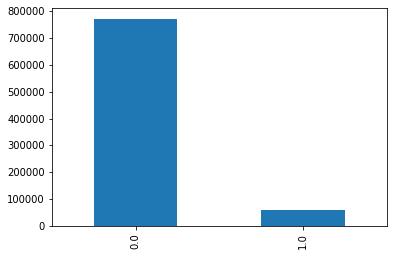

In [ ]:
train_feature['target'].value_counts().plot(kind='bar')
plt.show()

При построения модели надо иметь ввиду, что классы сильно несбалансированны

In [ ]:
date = pd.to_datetime(train_feature['buy_time_vt'], unit='s')
date.sample(5)

357542   2018-12-30 21:00:48
369996   2018-12-23 21:00:48
550805   2018-10-21 21:00:48
591495   2018-12-16 21:00:48
28477    2018-07-22 21:00:48
Name: buy_time_vt, dtype: datetime64[ns]

In [ ]:
date_features = pd.DataFrame()
date_features['month'] = date.dt.month
date_features['day'] = date.dt.day
date_features['dayofyear'] = date.dt.dayofyear
date_features['dayofweek'] = date.dt.dayofweek
date_features['weekofyear'] = date.dt.weekofyear
date_features.nunique()

<ipython-input-32-9fc76aaab98e>:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  date_features['weekofyear'] = date.dt.weekofyear


month          6
day           21
dayofyear     26
dayofweek      1
weekofyear    26
dtype: int64

Видим, что имеются наблюдения за 6 месяцев и все они относятся к одному дню недели

## Выделение целевой переменной

In [ ]:
X = train_feature.drop(['id','target','buy_time_vt'], axis=1)
y = train_feature['target']

## Определение типов признаков

In [ ]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

# Всего признаков
feat_all = set(X_nunique.index.tolist())
len(feat_all)

255

In [ ]:
# Константные признаки
feat_const = set(X_nunique[X_nunique == 1].index.tolist())
len(feat_const)

5

In [ ]:
# Вещественные признаки
feat_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
feat_numeric = set(feat_numeric[feat_numeric > 0].index.tolist())
len(feat_numeric)

248

In [ ]:
# Остальные признаки
feat_other = feat_all - (feat_numeric | feat_const )
len(feat_other)

2

Решим вопрос по остальным признакам...

In [ ]:
feat_categ = set(X_nunique.loc[feat_other][X_nunique.loc[feat_other] <= 10].index.tolist())
feat_categ

{'vas_id'}

In [ ]:
feat_other = feat_other - feat_categ
feat_other

{'252'}

In [ ]:
train_feature['252'].value_counts()

0.0       620789
1.0       210821
2.0            5
3.0            3
8.0            3
10.0           3
4.0            2
7.0            2
11.0           2
13.0           2
5.0            2
251.0          1
299.0          1
68.0           1
77.0           1
182.0          1
223.0          1
283.0          1
195.0          1
6.0            1
22.0           1
18.0           1
44.0           1
19.0           1
42.0           1
84.0           1
1743.0         1
16.0           1
24.0           1
284.0          1
Name: 252, dtype: int64

Определим признак {252} как категориальный, т.к. видим, что в основном значения в нем бинарные. Для этого оставим значения 0 и 1, остальное удалим

In [ ]:
X.loc[X['252']>1,:] = X['252'].value_counts().argmax()

In [ ]:
feat_categ = feat_categ | {'252'}
feat_other = feat_other - {'252'}
len(feat_other)

0

In [ ]:
# Признак time_diff обозначим как весовой тип
feat_weight = {'time_diff'}
feat_numeric = (feat_numeric | feat_other ) - feat_weight

Смотрим на общую картину по признакам...

In [ ]:
print('feat_all:', X.shape[1])
print()
print('feat_const:', len(feat_const))
print('feat_categorical:', len(feat_categ))
print('feat_numeric:', len(feat_numeric))
print('feat_weght:', len(feat_weight))


feat_ok = list(feat_categ | feat_numeric | feat_weight)
feat_categ, feat_numeric, feat_weight = list(feat_categ), list(feat_numeric), list(feat_weight)

feat_all: 255

feat_const: 5
feat_categorical: 2
feat_numeric: 247
feat_weght: 1


### **Следующий этап проекта - работа с моделями**

## **Логистическая регрессия**

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

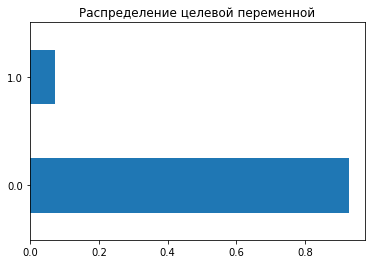

In [ ]:
(y.value_counts()/y.shape[0]).plot(kind='barh', title='Распределение целевой переменной');
y.value_counts()/y.shape

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X[feat_ok], y, train_size=0.1, test_size=0.033, random_state=123)

columns_data = X_train.columns.drop(feat_weight)

X_train_weight = X_train[feat_weight].values.flatten()
X_valid_weight = X_valid[feat_weight].values.flatten()

X_train = X_train.drop(feat_weight, axis=1)
X_valid = X_valid.drop(feat_weight, axis=1)

In [ ]:
print("Train")
print(y_train.value_counts()/y_train.shape)
print()
print("Test")
print(y_valid.value_counts()/y_valid.shape)

Train
0.0    0.927698
1.0    0.072302
Name: target, dtype: float64

Test
0.0    0.927892
1.0    0.072108
Name: target, dtype: float64


### **Пайплайн для обработки признаков**

Для логистической регрессии необходимо отмасштабировать числовые признаки и перекодировать в числовые категориальные признаки

In [ ]:
# пайплайн для числовых признаков
f_num_pipepline = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)

# пайплайн для категориальных признаков
f_cat_pipepline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)

# объединяющий пайплайн
preproc_pipeline = make_column_transformer(
    (f_num_pipepline, feat_numeric),
    (f_cat_pipepline, feat_categ)
)

### **Обучение модели с использованием пайплайна**

In [ ]:
logreg_pp = Pipeline([
    ('prepoc', preproc_pipeline),
    ('selector', SelectPercentile()),
    ('model', LogisticRegression(n_jobs=-1,
                                 random_state=123,
                                 class_weight='balanced',
                                 max_iter=200))
])

In [ ]:
params = {
    'selector__percentile': [5, 10, 20],
    'model__C': [0.01, 0.1, 5]   
}

In [ ]:
logreg_model = GridSearchCV(estimator=logreg_pp,
                            param_grid=params,
                            cv=3,
                            scoring='roc_auc',
                            n_jobs=-1,
                            verbose=1,
                            refit=True)

In [ ]:
lrm = logreg_model.fit(X_train, y_train, model__sample_weight=X_train_weight)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


In [ ]:
logreg_model.best_params_

{'model__C': 0.1, 'selector__percentile': 10}

In [ ]:
logreg_proba_1 = logreg_model.predict_proba(X_valid)[:,1]
logreg_pred = logreg_model.predict(X_valid)

### **Анализ результатов предсказания**

ROC-кривая

LogisticRegression: AUC_ROC = 0.845


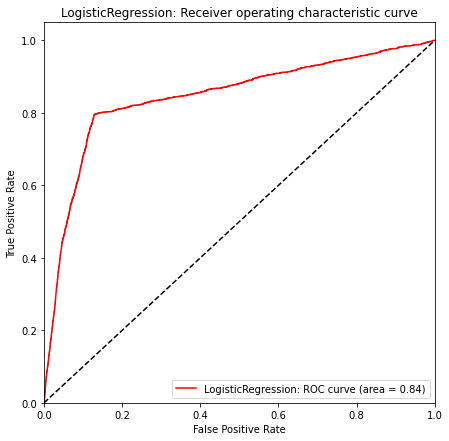

In [ ]:
fpr, tpr, lrm = roc_curve(y_valid, logreg_proba_1)
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "LogisticRegression", color='r')
print("LogisticRegression: AUC_ROC = %.3f" % auc(fpr, tpr))

Precision-Recall-кривая

LogisticRegression: AUC_PR = 0.353


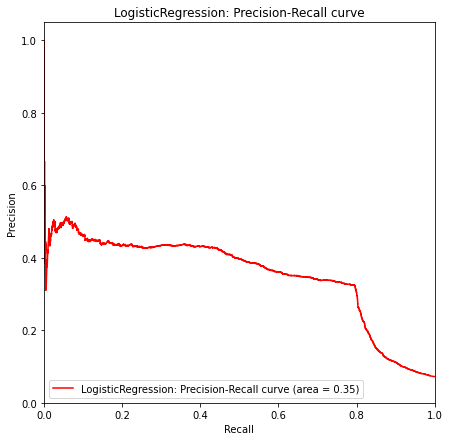

In [ ]:
precision, recall, lrm = precision_recall_curve(y_valid, logreg_proba_1)

plt.figure(figsize=(7, 7))    
plot_precision_recall_curve(precision, recall, "LogisticRegression", color='r')
print("LogisticRegression: AUC_PR = %.3f" % auc(recall, precision))

### **Матрица смежности**

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[22177  3289]
 [  405  1574]]


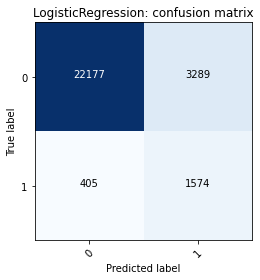

In [ ]:
cm = confusion_matrix(y_valid, logreg_pred > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="LogisticRegression");

Матрица смежности показывает

* в левом верхнем углу количество истинных предсказаний класса 0

* в правом верхнем углу количество ложных предсказаний класса 1 (ошибка второго рода)

* в левом нижнем углу количество ложных предсказаний класса 0 (ошибка первого рода)

* в правом нижнем углу количество истинных предсказаний класса 1


Если принять за нулевую гипотезу - положительный отклик клиента на услугу (класс 1), и осуществлять клиентам рассылку предложений по подключению услуги согласно предсказаниям модели, то

* количество ошибок первого рода характеризует сколько клиентов не получили предложения, хотя потенцаильно они готовы совершить подключение;

* количество ошибок второго рода характеризует сколько клиентов получили предложения, хотя они не собираются совершать подключение.

In [ ]:
# выбирем порог 0.5
print(classification_report(y_valid, logreg_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25466
         1.0       0.32      0.80      0.46      1979

    accuracy                           0.87     27445
   macro avg       0.65      0.83      0.69     27445
weighted avg       0.93      0.87      0.89     27445



## **Catboost**

In [ ]:
selector = SelectPercentile()
X_cat = selector.fit_transform(X[feat_ok], y)
columns = X[feat_ok].columns
support = selector.get_support()
selected_columns = columns[support]

for feat in feat_categ+feat_weight:
    assert feat in selected_columns

X_cat = pd.DataFrame(X_cat, columns=selected_columns)

X_cat[feat_categ] = X_cat[feat_categ].astype('int').astype('category')

In [ ]:
X_train_cat, X_valid_cat, y_train_cat, y_valid_cat = train_test_split(X_cat, y,
                                                                      train_size=0.1,
                                                                      test_size=0.033,
                                                                      random_state=123)

In [ ]:
cat_params = {
    'loss_function':'Logloss',
    'eval_metric': 'F1',
    'auto_class_weights': 'Balanced',
    'random_state': 123,
    'logging_level': 'Verbose',
    # 'task_type': 'GPU',
    'cat_features': feat_categ,
    'one_hot_max_size': 25,
    'early_stopping_rounds': 50,
}

In [ ]:
%%time

cat_model = CatBoostClassifier(**cat_params)

params_grid = {
    'iterations': [100, 200, 500],
    'learning_rate': [0.03, 0.1, 0.3],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 5, 10, 20],
    'bagging_temperature': [1, 1.5, 2]
}

CPU times: user 178 µs, sys: 0 ns, total: 178 µs
Wall time: 184 µs


### **Рандомизированный поиск по сетке с применением кросс-валидации**

Случайным образом по сетке параметров выбирается и проверяется 20 наборов гиперпараметров

In [ ]:
%%time

search_result = cat_model.randomized_search(params_grid,
                                            X=X_train_cat,
                                            y=y_train_cat,
                                            cv=3,
                                            stratified=True,
                                            search_by_train_test_split=False,
                                            n_iter=10)

Training on fold [0/3]
0:	learn: 0.8139155	test: 0.8120253	best: 0.8120253 (0)	total: 24.1ms	remaining: 12s
1:	learn: 0.8194637	test: 0.8179599	best: 0.8179599 (1)	total: 47.7ms	remaining: 11.9s
2:	learn: 0.8142779	test: 0.8124037	best: 0.8179599 (1)	total: 75.7ms	remaining: 12.5s
3:	learn: 0.8139740	test: 0.8120918	best: 0.8179599 (1)	total: 104ms	remaining: 12.9s
4:	learn: 0.8214571	test: 0.8193987	best: 0.8193987 (4)	total: 127ms	remaining: 12.6s
5:	learn: 0.8220012	test: 0.8216093	best: 0.8216093 (5)	total: 151ms	remaining: 12.5s
6:	learn: 0.8218195	test: 0.8205343	best: 0.8216093 (5)	total: 177ms	remaining: 12.5s
7:	learn: 0.8216744	test: 0.8202610	best: 0.8216093 (5)	total: 205ms	remaining: 12.6s
8:	learn: 0.8220346	test: 0.8216259	best: 0.8216259 (8)	total: 235ms	remaining: 12.8s
9:	learn: 0.8220063	test: 0.8216924	best: 0.8216924 (9)	total: 257ms	remaining: 12.6s
10:	learn: 0.8220262	test: 0.8212536	best: 0.8216924 (9)	total: 292ms	remaining: 13s
11:	learn: 0.8220513	test: 0.82

In [ ]:
best_cat_params = search_result['params']
best_cat_params

{'bagging_temperature': 2,
 'depth': 4,
 'l2_leaf_reg': 5,
 'iterations': 500,
 'learning_rate': 0.03}

In [ ]:
cat_proba_1 = cat_model.predict_proba(X_valid_cat)[:,1]
cat_pred = cat_model.predict(X_valid_cat)

ROC-кривая

CatBoostClassifier: AUC_ROC = 0.864
LogisticRegression: AUC_ROC = 0.845


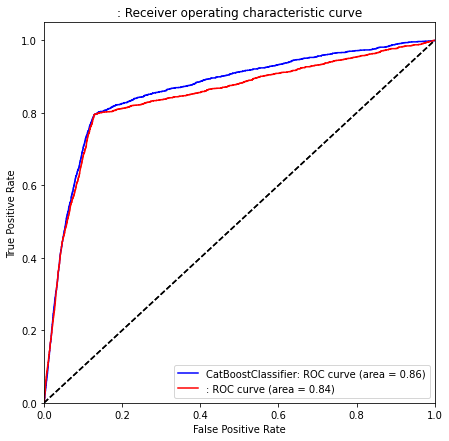

In [ ]:
fpr, tpr, lrm = roc_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, lrm = roc_curve(y_valid, logreg_proba_1)
plot_roc_curve(fpr, tpr, "", color='r')
print("LogisticRegression: AUC_ROC = %.3f" % auc(fpr, tpr))

Precision-Recall-кривая

CatBoostClassifier: AUC_PR = 0.356
LogisticRegression: AUC_PR = 0.353


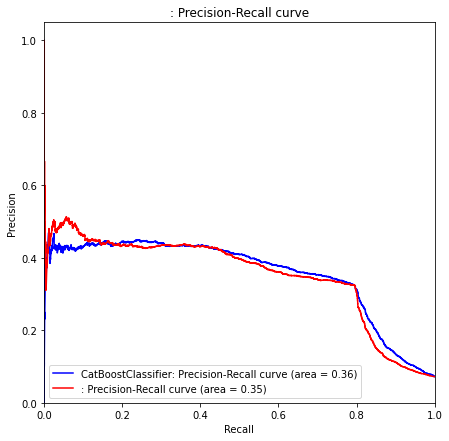

In [ ]:
precision, recall, lrm = precision_recall_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))    
plot_precision_recall_curve(precision, recall, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_PR = %.3f" % auc(recall, precision))

precision, recall, lrm = precision_recall_curve(y_valid, logreg_proba_1) 
plot_precision_recall_curve(precision, recall, "", color='r')
print("LogisticRegression: AUC_PR = %.3f" % auc(recall, precision))

### **Матрица смежности**

Confusion matrix, without normalization
[[22193  3273]
 [  407  1572]]


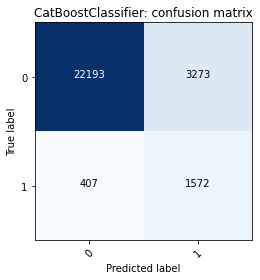

In [ ]:
cm = confusion_matrix(y_valid_cat,cat_pred)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="CatBoostClassifier");

In [ ]:
print('LogisticRegression')
print(classification_report(y_valid, logreg_pred > 0.5))

LogisticRegression
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25466
         1.0       0.32      0.80      0.46      1979

    accuracy                           0.87     27445
   macro avg       0.65      0.83      0.69     27445
weighted avg       0.93      0.87      0.89     27445



## **XGBoost**

In [ ]:
xgb_pp = make_pipeline(
    xgb.XGBClassifier(random_state=123, 
                              n_estimators=100,
                              learning_rate=0.1,
                              max_depth=5,
                              eval_metric='error',
                              use_label_encoder=False)
)

xgb_pp.fit(X_train, y_train)
# y_predict = xgb_pp.predict_proba(X_valid)[:, 1]
# y_predict

Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(eval_metric='error', max_depth=5,
                               random_state=21, use_label_encoder=False))])

In [ ]:
xbg_pred_prob = xgb_pp.predict_proba(X_valid)[:, 1]
xbg_pred = xgb_pp.predict(X_valid)

CatBoostClassifier: AUC_ROC = 0.863
LogisticRegression: AUC_ROC = 0.845
XGBClassifier: AUC_ROC = 0.846


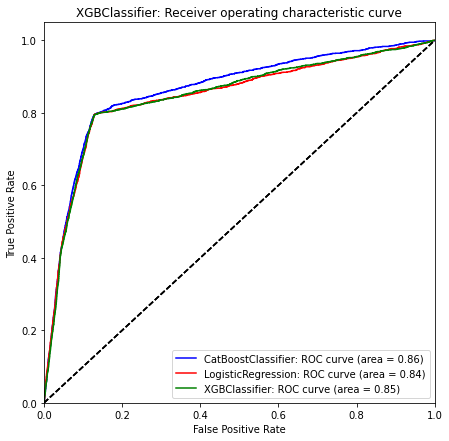

In [ ]:
fpr, tpr, lrm = roc_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, lrm = roc_curve(y_valid, logreg_proba_1)
plot_roc_curve(fpr, tpr, "LogisticRegression", color='r')
print("LogisticRegression: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, lrm = roc_curve(y_valid, xbg_pred_prob)
plot_roc_curve(fpr, tpr, "XGBClassifier", color='g')
print("XGBClassifier: AUC_ROC = %.3f" % auc(fpr, tpr))

CatBoostClassifier: AUC_PR = 0.355
LogisticRegression: AUC_PR = 0.353
XGBClassifier: AUC_PR = 0.341


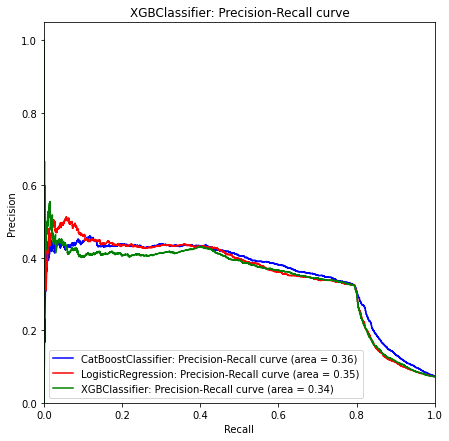

In [ ]:
precision, recall, lrm = precision_recall_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))    
plot_precision_recall_curve(precision, recall, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_PR = %.3f" % auc(recall, precision))

precision, recall, lrm = precision_recall_curve(y_valid, logreg_proba_1) 
plot_precision_recall_curve(precision, recall, "LogisticRegression", color='r')
print("LogisticRegression: AUC_PR = %.3f" % auc(recall, precision))

precision, recall, lrm = precision_recall_curve(y_valid, xbg_pred_prob) 
plot_precision_recall_curve(precision, recall, "XGBClassifier", color='g')
print("XGBClassifier: AUC_PR = %.3f" % auc(recall, precision))

Confusion matrix, without normalization
[[25404    62]
 [ 1930    49]]


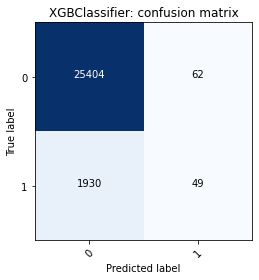

In [ ]:
cm = confusion_matrix(y_valid,xbg_pred)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="XGBClassifier");

In [ ]:
print('LogisticRegression')
print(classification_report(y_valid, logreg_pred > 0.5))
print()
print('CatBoostClassifier')
print(classification_report(y_valid_cat,cat_pred))
print()
print('XGBClassifier')
print(classification_report(y_valid, xbg_pred))

LogisticRegression
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25466
         1.0       0.32      0.80      0.46      1979

    accuracy                           0.87     27445
   macro avg       0.65      0.83      0.69     27445
weighted avg       0.93      0.87      0.89     27445


CatBoostClassifier
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25466
         1.0       0.32      0.79      0.46      1979

    accuracy                           0.87     27445
   macro avg       0.65      0.83      0.69     27445
weighted avg       0.93      0.87      0.89     27445


XGBClassifier
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     25466
         1.0       0.44      0.02      0.05      1979

    accuracy                           0.93     27445
   macro avg       0.69      0.51      0.50     27445
weighted avg       0

## **DecisionTreeClassifier**

In [ ]:
model_DecisionTree = DecisionTreeClassifier(random_state=123,
                                    #criterion='gini',
#                                    class_weight={0:1, 1:disbalance},
                                    min_impurity_decrease=3,
                                    min_samples_split=5,
                                    min_samples_leaf=5,
                                    max_depth=3
                                    )
model_DecisionTree

DecisionTreeClassifier(max_depth=3, min_impurity_decrease=3, min_samples_leaf=5,
                       min_samples_split=5, random_state=123)

In [ ]:
DecisionTree_pp = make_pipeline(
    model_DecisionTree
)
DecisionTree_pp.fit(X_train, y_train)

Pipeline(steps=[('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3, min_impurity_decrease=3,
                                        min_samples_leaf=5, min_samples_split=5,
                                        random_state=123))])

In [ ]:
dt_pred_prob = DecisionTree_pp.predict_proba(X_valid)[:, 1]
dt_pred = DecisionTree_pp.predict(X_valid)

CatBoostClassifier: AUC_ROC = 0.863
LogisticRegression: AUC_ROC = 0.845
XGBClassifier: AUC_ROC = 0.846
DecisionTreeClassifier: AUC_ROC = 0.500


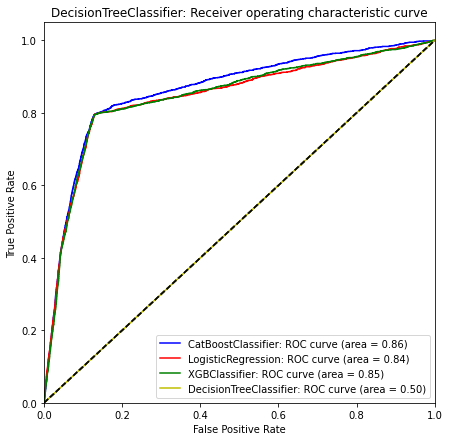

In [ ]:
fpr, tpr, lrm = roc_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, lrm = roc_curve(y_valid, logreg_proba_1)
plot_roc_curve(fpr, tpr, "LogisticRegression", color='r')
print("LogisticRegression: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, lrm = roc_curve(y_valid, xbg_pred_prob)
plot_roc_curve(fpr, tpr, "XGBClassifier", color='g')
print("XGBClassifier: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, lrm = roc_curve(y_valid, dt_pred_prob)
plot_roc_curve(fpr, tpr, "DecisionTreeClassifier", color='y')
print("DecisionTreeClassifier: AUC_ROC = %.3f" % auc(fpr, tpr))

CatBoostClassifier: AUC_PR = 0.355
LogisticRegression: AUC_PR = 0.353
XGBClassifier: AUC_PR = 0.341
GradientBoosting: AUC_PR = 0.536


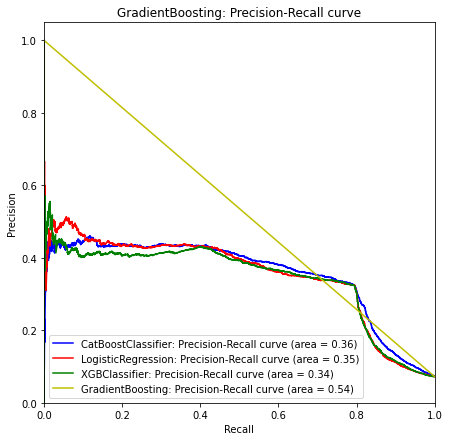

In [ ]:
precision, recall, lrm = precision_recall_curve(y_valid_cat, cat_proba_1)
plt.figure(figsize=(7, 7))    
plot_precision_recall_curve(precision, recall, "CatBoostClassifier", color='b')
print("CatBoostClassifier: AUC_PR = %.3f" % auc(recall, precision))

precision, recall, lrm = precision_recall_curve(y_valid, logreg_proba_1) 
plot_precision_recall_curve(precision, recall, "LogisticRegression", color='r')
print("LogisticRegression: AUC_PR = %.3f" % auc(recall, precision))

precision, recall, lrm = precision_recall_curve(y_valid, xbg_pred_prob) 
plot_precision_recall_curve(precision, recall, "XGBClassifier", color='g')
print("XGBClassifier: AUC_PR = %.3f" % auc(recall, precision))

precision, recall, lrm = precision_recall_curve(y_valid, dt_pred_prob) 
plot_precision_recall_curve(precision, recall, "DecisionTreeClassifier", color='y')
print("DecisionTreeClassifier: AUC_PR = %.3f" % auc(recall, precision))

Confusion matrix, without normalization
[[25466     0]
 [ 1979     0]]


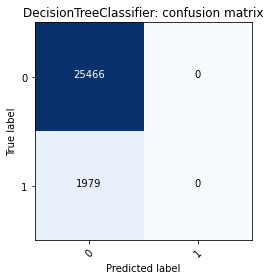

In [ ]:
cm = confusion_matrix(y_valid,dt_pred)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="DecisionTreeClassifier");

In [ ]:
print('LogisticRegression')
print(classification_report(y_valid, logreg_pred > 0.5))
print()
print('CatBoostClassifier')
print(classification_report(y_valid_cat,cat_pred))
print()
print('XGBClassifier')
print(classification_report(y_valid, xbg_pred))
print()
print('DecisionTreeClassifier')
print(classification_report(y_valid, dt_pred))

LogisticRegression
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25466
         1.0       0.32      0.80      0.46      1979

    accuracy                           0.87     27445
   macro avg       0.65      0.83      0.69     27445
weighted avg       0.93      0.87      0.89     27445


CatBoostClassifier
              precision    recall  f1-score   support

         0.0       0.98      0.87      0.92     25466
         1.0       0.32      0.79      0.46      1979

    accuracy                           0.87     27445
   macro avg       0.65      0.83      0.69     27445
weighted avg       0.93      0.87      0.89     27445


XGBClassifier
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     25466
         1.0       0.44      0.02      0.05      1979

    accuracy                           0.93     27445
   macro avg       0.69      0.51      0.50     27445
weighted avg       0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Финальная модель и предсказание на тестовых данных**

In [ ]:
selector = SelectPercentile()
X_cat_fin = selector.fit_transform(X[feat_ok], y)
columns = X[feat_ok].columns
support = selector.get_support()
selected_columns = columns[support]

for feat in feat_categ+feat_weight:
    assert feat in selected_columns

X_cat_fin = pd.DataFrame(X_cat_fin, columns=selected_columns)

X_cat_fin[feat_categ] = X_cat_fin[feat_categ].astype('int').astype('category')

## **Обучение финальной модели. Финальную модель выберем Catboost**

In [ ]:
fin_model = CatBoostClassifier(**cat_params,
                               **best_cat_params)

In [ ]:
%%time

fin_model.fit(X=X_cat_fin, y=y)

0:	learn: 0.8213920	total: 246ms	remaining: 2m 2s
1:	learn: 0.8213920	total: 427ms	remaining: 1m 46s
2:	learn: 0.8213920	total: 608ms	remaining: 1m 40s
3:	learn: 0.8213920	total: 804ms	remaining: 1m 39s
4:	learn: 0.8213920	total: 983ms	remaining: 1m 37s
5:	learn: 0.8213920	total: 1.18s	remaining: 1m 37s
6:	learn: 0.8213920	total: 1.37s	remaining: 1m 36s
7:	learn: 0.8213920	total: 1.55s	remaining: 1m 35s
8:	learn: 0.8213920	total: 1.75s	remaining: 1m 35s
9:	learn: 0.8213920	total: 1.92s	remaining: 1m 34s
10:	learn: 0.8213920	total: 2.13s	remaining: 1m 34s
11:	learn: 0.8213920	total: 2.37s	remaining: 1m 36s
12:	learn: 0.8213920	total: 2.57s	remaining: 1m 36s
13:	learn: 0.8213920	total: 2.76s	remaining: 1m 35s
14:	learn: 0.8213920	total: 3.07s	remaining: 1m 39s
15:	learn: 0.8213920	total: 3.42s	remaining: 1m 43s
16:	learn: 0.8213920	total: 3.79s	remaining: 1m 47s
17:	learn: 0.8213920	total: 4.2s	remaining: 1m 52s
18:	learn: 0.8213920	total: 4.58s	remaining: 1m 55s
19:	learn: 0.8213920	tot

### **Cохранение финальной модели в pickle**

In [ ]:
import pickle
with open('final_model.pkl', 'wb') as file:
        pickle.dump(fin_model, file)

### **Прогнозирование на тестовом датасете**

In [ ]:
w_sc = StandardScaler().fit_transform(test_feature['time_diff'].values.reshape(-1,1))
w = 1 / (1 + np.exp(w_sc))

assert not np.isnan(w).any()

test_feature['time_diff'] = w

X_test = test_feature.drop(['id','buy_time_vt'], axis=1)

X_test.loc[X_test['252']>1,:] = X_test['252'].value_counts().argmax()

X_cat_test = selector.transform(X_test[feat_ok])

X_cat_test = pd.DataFrame(X_cat_test, columns=selected_columns)

X_cat_test[feat_categ] = X_cat_test[feat_categ].astype('int').astype('category')

In [ ]:
test_pred_proba = fin_model.predict_proba(X_cat_test)[:,1]

### **Сформируем файл с предсказаниями и сохраним его в answers_test.csv**

In [ ]:
answers_test = test_feature[['buy_time_vt', 'id', 'vas_id']].rename(columns={'buy_time_vt': 'buy_time'}).copy()

In [ ]:
answers_test['target'] = test_pred_proba

In [ ]:
answers_test.head()

,buy_time,id,vas_id,target
0,1.548018e+09,3130519.0,2.0,0.132343
1,1.548018e+09,2000860.0,4.0,0.785261
2,1.546808e+09,1099444.0,2.0,0.147167
3,1.547413e+09,1343255.0,5.0,0.141600
4,1.546808e+09,1277040.0,2.0,0.158244


In [ ]:
answers_test.to_csv('answers_test.csv')